<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/RNN/predict_alternating_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

- Implement an RNN to predict a data sequence.
- Use small snippets of data (a mini sequence cut out of the longer time series) in order to predict whether the following data has a positive or negative value.
  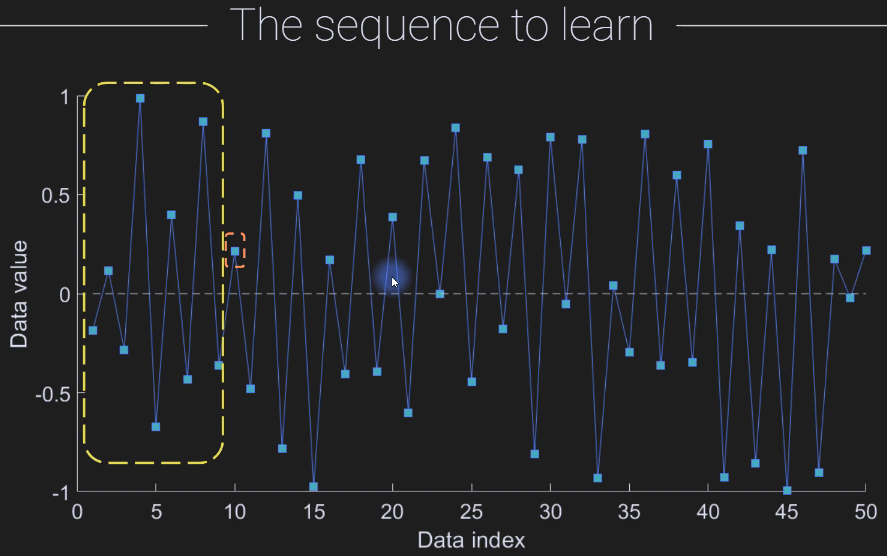

In [47]:
import torch
import torch.nn as nn
import numpy as np

import sys # for printing out status reports

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# Create temporal sequence data:

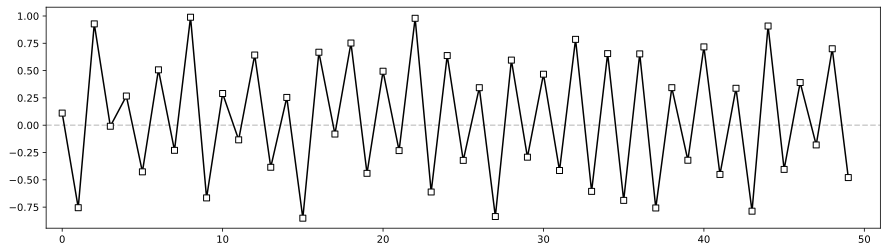

In [48]:
# generate the data
N = 50
data = torch.zeros(N)

for i in range(N):
  data[i] = torch.rand(1) * (-1)**i # generate alternating pos/neg nums from a uniform distribution on the interval [0,1)

# show the data sequence
plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8]) # draw a horizontal dashed line at y=0 from x=-1 to x=N+1 in light gray (RGB)
plt.plot(data,'ks-',markerfacecolor='w') # a solid line connecting black squares
plt.xlim([-1,N+1]) # set the limits of the x-axis
plt.show() # display the plot

In [49]:
data.shape

torch.Size([50])

# Create a class for the DL model:

In [50]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)

    # linear layer for output
    self.out = nn.Linear(num_hidden,1) # 1 output (pos/neg)

  def forward(self, x):
    # push through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization

    # push through the linear layer (output)
    y = self.out(y)

    return y,hidden

In [51]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # number of units in hidden layers
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  9 # number of datapoints used for learning in each segment
batchsize  =  1

# create an instance of the model
net = rnnnet(input_size,num_hidden,num_layers)

# generate fake data & pass the fake data through the model instance
X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X) # output, hidden
print(X.shape) # input size
print(y.shape) # output size
print(h.shape) # hidden size

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [52]:
# test the model with the actual data
somedata = data[:seqlength].view(seqlength,1,1) # take a slice (vector) & reshape to tensor
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1] # y[0]: output, y[1]: hidden
print(finalValue.shape)
print("predicted value:", finalValue)

# loss func & calc loss
lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1)) # predicted value vs. the next value (true value)

torch.Size([1, 1])
predicted value: tensor([[0.5081]], grad_fn=<SelectBackward0>)


tensor(1.3776, grad_fn=<MseLossBackward0>)

# Train the model:

In [53]:
numepochs = 30

# create a new instance of the model & optimizer
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  # loop over data segments
  for timei in range(N-seqlength):
    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass & loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # store loss from this segment
    seglosses.append(loss.item())

    # also get sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    # squeeze function in PyTorch is used to remove dimensions with size 1 from the tensor
    # detach method is used to create a new tensor that shares data with finalValue but does not require gradients (detach a tensor from the computation graph)
    # numpy method is used to convert the PyTorch tensor to a NumPy array
    # np.sign function computes the sign of each element in the array
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

In [54]:
truesign

-1.0

In [55]:
predsign

-1.0

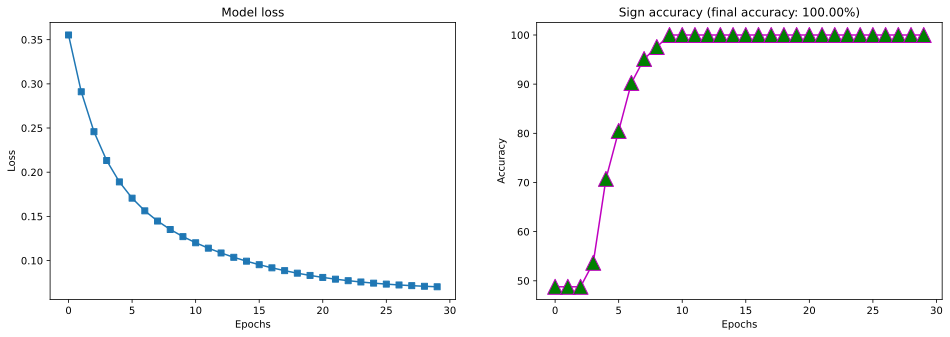

In [56]:
# visualize:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

# Test the network:

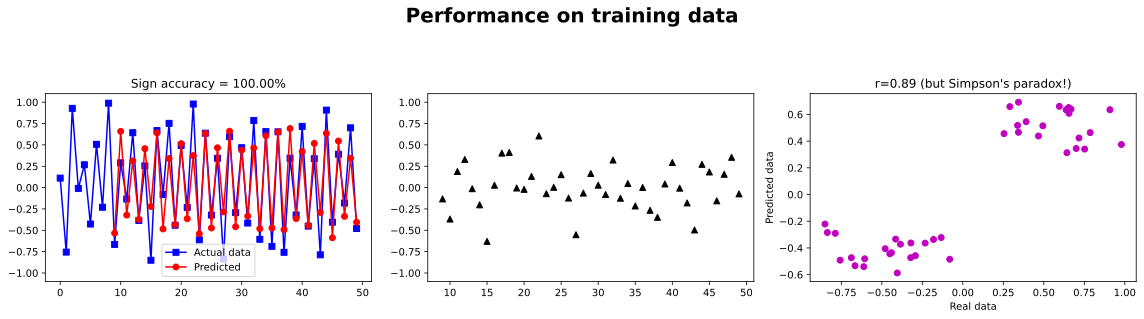

In [57]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan

# loop over time segments
for timei in range(N-seqlength):
  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()

# compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])

# visualize
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

# Predicting the sign from idx 9 (no predictions for the first couple of data points), the numerical values are totally random and unpredictable.

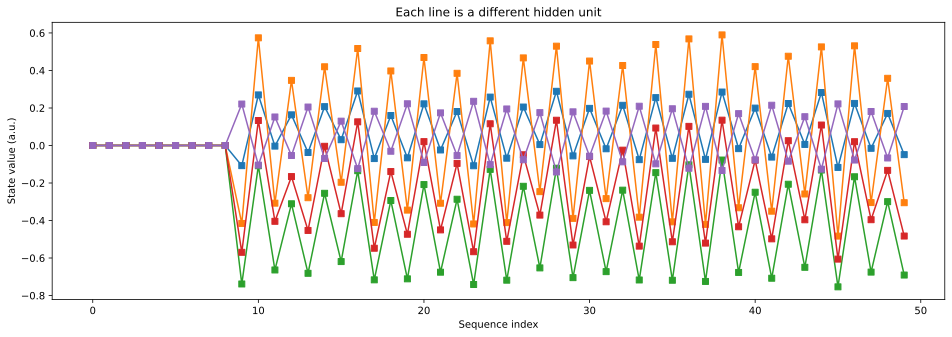

In [58]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

# Test with new data with flipped signs:

In [59]:
# create new data WITH FLIPPED SIGNS:

newdata = torch.zeros(N)
for i in range(N):
  newdata[i] = torch.rand(1) * (-1)**(i+1)

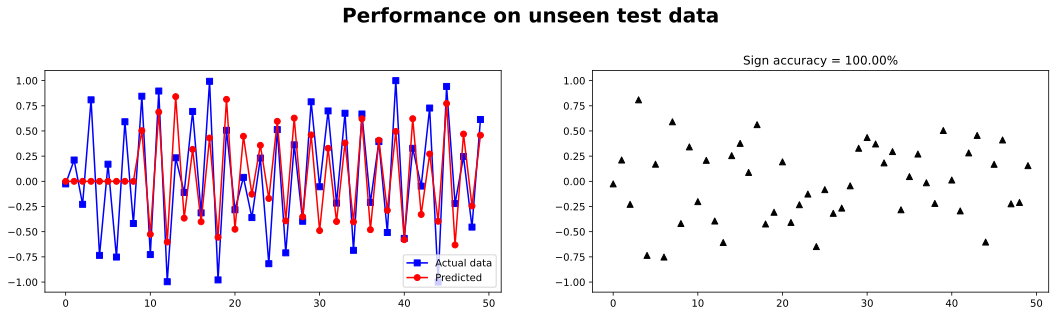

In [60]:
# now test the network:

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()

# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])

fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

👆It's nice to see the model actually learned the sequence of signs and it didn't simply memorize plus minus, plus, minus.

/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.10/dist-packages/numpy/lib/stride_tricks.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/loc

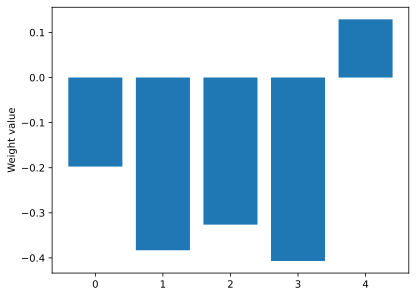

In [61]:
# plot the weights for the input->hidden layers:

plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()